<a href="https://colab.research.google.com/github/polrib/StatisticalLearningCourse/blob/main/Final_Project_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WALKING PATTERN RECOGNITION**

##**Import libraries**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **Import Data**

In [ ]:
# Drive's mount

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = {'pol':{'data': None, 'clean_data': None, 'ts_diff': None, 'params': {}},
        'matteo':{'data': None, 'clean_data': None, 'ts_diff': None, 'params': {}}}

data['pol']['data'] = pd.read_csv('/content/drive/My Drive/SL_project/Pol_Registrazione_Final.csv')
data['matteo']['data'] = pd.read_csv('/content/drive/My Drive/SL_project/Matteo_last_rec.csv')

columns = ['AccX','AccY','AccZ'] # Selected columns

# **Data Pre-Processing**


In [ ]:
def plot_data(df, cols=None, figsize=(15, 10)):
    if cols:
        columns = cols
    else:
        columns = df.columns

    fig=plt.figure(figsize=figsize)
    col_len = len(columns)

    for col_idx, name in enumerate(columns):
        num = int(''.join([str(col_len),'1',str(col_idx+1)])) #311, 312, ...
        plt.subplot(num)
        plt.title(str(name))
        plt.plot(df.iloc[:,col_idx], linewidth=1)
        plt.grid()

## **Data cleaning**

In [ ]:
# CLEANING FUNCTION
# This function cleans the selected columns and returns a dataframe with these columns
def clean_data(df, col_names):
    temp_data = pd.DataFrame() 
    df_mod = df.copy().dropna(thresh=3)
    for col in col_names:
        temp_data = pd.concat([temp_data, df_mod[col].interpolate().reset_index(drop=True)], ignore_index=True, axis=1).dropna()
    temp_data.columns = col_names
    return temp_data

In [ ]:
# Drop na rows from dataset

# Data cleaning
for name in data:
    try:
       data[name]['clean_data'] =  clean_data(df=data[name]['data'].copy(), col_names=columns)
    except Exception:
        print(f'No {name.title()}\'s data!')

# Output info
for name in data:
    try:
        print(f"Original {name.title()}'s data shape: {data[name]['data'].shape} \nClean data shape: {data[name]['clean_data'].shape}")
        #print(data[name]['clean_data'])
    except:
        pass

Original Pol's data shape: (23888, 4) 
Clean data shape: (17138, 3)
Original Matteo's data shape: (25848, 4) 
Clean data shape: (18669, 3)


### Example: Raw Data

In [ ]:
# Example of raw data
prova = data['matteo']['data']
prova.head(30)

,timestamp,AccX,AccY,AccZ
0,1600256926944,0.292104,1.559023,9.836598
1,1600256926996,0.349382,1.737110,9.256293
2,1600256927057,0.392659,1.559099,9.852913
3,1600256927118,0.428309,1.542316,9.596480
4,1600256927179,0.298874,1.439310,9.739617
5,1600256927240,0.431549,1.430770,9.924892
6,1600256927302,0.442825,1.495770,9.797784
7,1600256927362,NaN,NaN,9.509841
8,1600256927363,0.545637,1.663572,NaN
9,1600256927423,0.673730,1.838111,9.429624


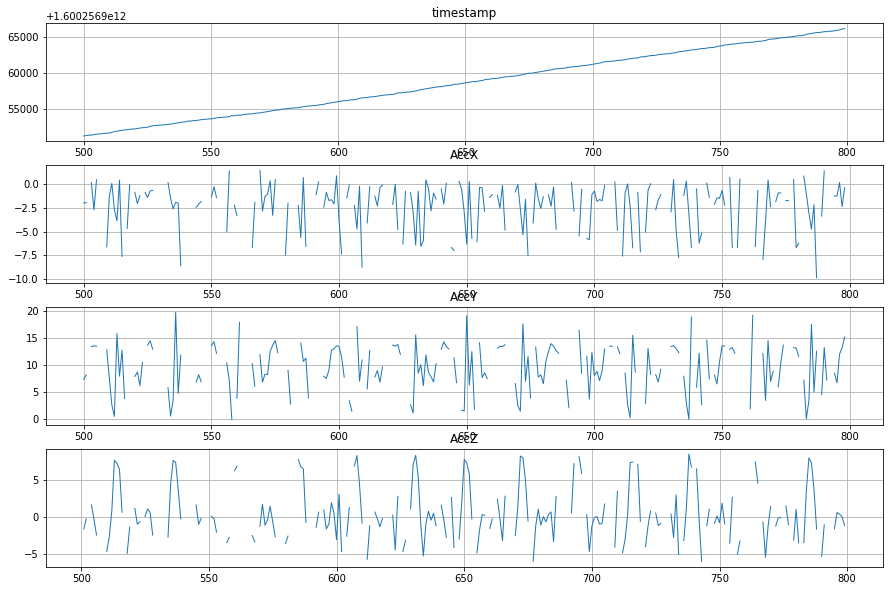

In [ ]:
# Plot of raw data 
plot_data(df=prova[500:800])

### **Example: Clean Data**

In [ ]:
prova_cleaned = clean_data(prova, col_names=columns) 
prova_cleaned.head(10)

,AccX,AccY,AccZ
0,0.292104,1.559023,9.836598
1,0.349382,1.737110,9.256293
2,0.392659,1.559099,9.852913
3,0.428309,1.542316,9.596480
4,0.298874,1.439310,9.739617
5,0.431549,1.430770,9.924892
6,0.442825,1.495770,9.797784
7,0.545637,1.663572,9.613704
8,0.673730,1.838111,9.429624
9,0.653886,1.818907,9.545283


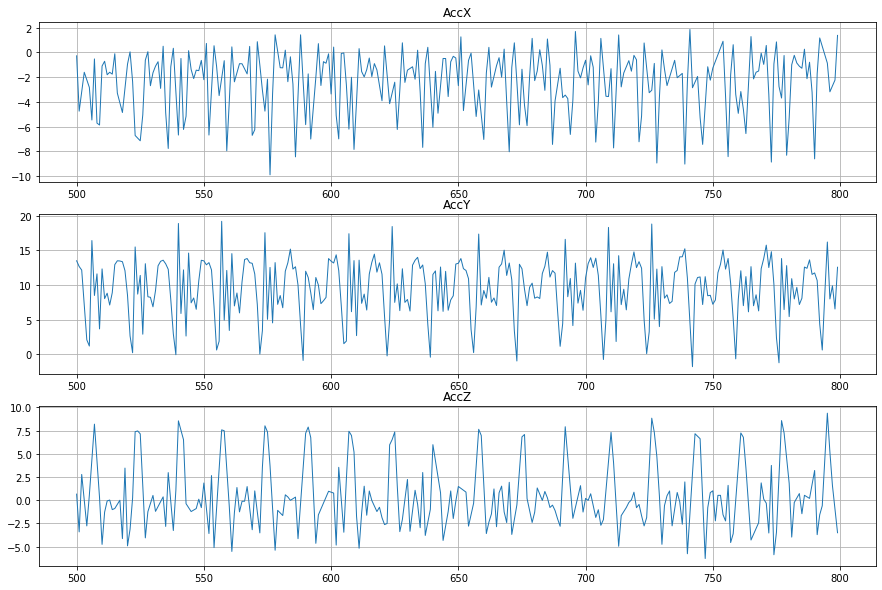

In [ ]:
plot_data(prova_cleaned[500:800])

## **Sampling Rate**

**Problems:**


1.   Different number of pattern for each person (generally each of us had taken ~30 min. of waling signal!)
2.  Different values in the features.
3. [Aliasing problem](https://en.wikipedia.org/wiki/Aliasing)



In [ ]:
# The function

def get_ts_diff(df, th_min, th_max, col, show_info=True):
    df_copy = df[col].copy().dropna(thresh=3)
    ts = df_copy['timestamp'].diff().copy()
    ts = ts[(ts>th_min) & (ts<th_max)]
    if show_info:
        print(f"\n{name.title()}'s timestamps differences statistics:\n")
        print(ts.describe())
        #print('\nPrincipal frequencies:\n')
        #print(ts.value_counts(normalize=True))
    return ts

We will exclude all the sampling greater or smaller than these two thresholds:

In [ ]:
th_min = 10
th_max = 100

Some statistics about delta-timestamps:

In [ ]:
for name in data:
    try:
        data[name]['ts_diff'] = get_ts_diff(data[name]['data'], th_min=th_min, th_max=th_max, col=['timestamp','AccX','AccY','AccZ'])
    except Exception:
        print(f'No {name.title()}\'s timestamps!')


Pol's timestamps differences statistics:

count    16175.000000
mean        74.284884
std         12.251162
min         23.000000
25%         73.000000
50%         78.000000
75%         79.000000
max         97.000000
Name: timestamp, dtype: float64

Matteo's timestamps differences statistics:

count    16725.000000
mean        60.503318
std          3.802348
min         28.000000
25%         60.000000
50%         61.000000
75%         62.000000
max         99.000000
Name: timestamp, dtype: float64


### **Plot Hists**

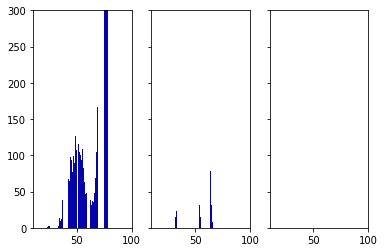

In [ ]:
# Time diff's histogram
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True)

for index, name in enumerate(data):
    try:
        axs[index].hist(data[name]['ts_diff'], bins='auto', color='#0504aa')
        plt.xlim(th_min, th_max)
        plt.ylim(0, 300)
    except Exception:
        pass

## **Upsampling**

The recordings are taken from different smartphone with different sampling rates. In order to get more homogeneus data, we will upsample all of them to the same rate (~20ms).

In [ ]:
from scipy.signal import resample_poly
from warnings import warn

def upsample(data, diff_data):
    mean_ = diff_data.mean()
    median_ = diff_data.median()
    if abs(mean_ - median_) >= 5:
        warn(f'The difference between mean and median of {abs(mean_ - median_)} is greter than the threshold!')
    else:
        new_data = pd.DataFrame()
        up_factor = round( median_ / 20) # this value must be an integer
        for col in data:
            new_data[col] = resample_poly(x=data[col], up=up_factor, down=1)
        return new_data, up_factor

In [ ]:
# Upsample the data:
for name in data:
    try:
        print(f"Original {name.title()}'s data shape: {data[name]['clean_data'].shape} ")
        up_data, up_factor = upsample(data=data[name]['clean_data'],
                                            diff_data=data[name]['ts_diff'])
        data[name]['clean_data'] = up_data
        data[name]['params']['up_factor'] = up_factor 
        print(f"Upsampled {name.title()}'s data shape: {data[name]['clean_data'].shape} - Upsampling fatcor: {data[name]['params']['up_factor']}")
    except:
        pass

Original Pol's data shape: (17138, 3) 
Upsampled Pol's data shape: (68552, 3) - Upsampling fatcor: 4
Original Matteo's data shape: (18669, 3) 
Upsampled Matteo's data shape: (56007, 3) - Upsampling fatcor: 3


### **Example**

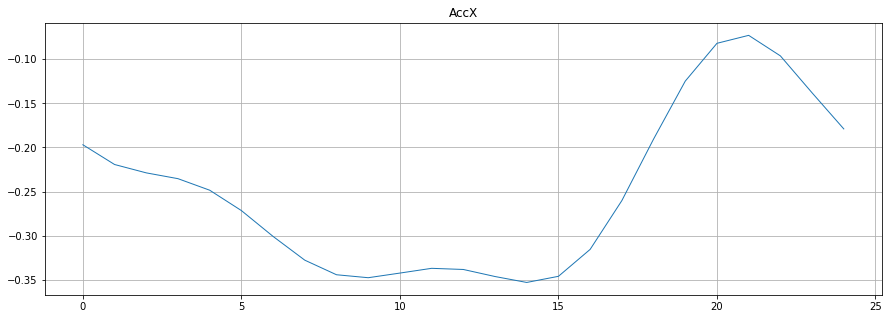

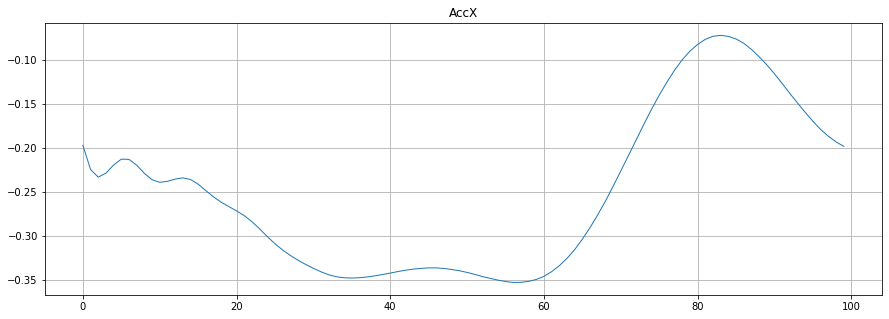

In [ ]:
trial_data, upf = upsample(data=data['pol']['clean_data'],
         diff_data=data['pol']['ts_diff'])

plot_data(data['pol']['clean_data'][:int(100 / upf)], cols=['AccX'], figsize=(15,5))
plot_data(trial_data[:100], cols=['AccX'], figsize=(15,5))

## **New Column: AccXYZ**

In [ ]:
# New column: AccXYZ
for name in data:
    try:
        data[name]['clean_data']['AccXYZ'] = data[name]['clean_data'].apply(lambda x: (x.AccX**2 + x.AccY**2 + x.AccZ**2)**(0.5), axis=1)
    except Exception as e:
        print(f'{name.title()} EXCEPTION: {e}')

### Plot

## **Rotate Data (Normalization)**

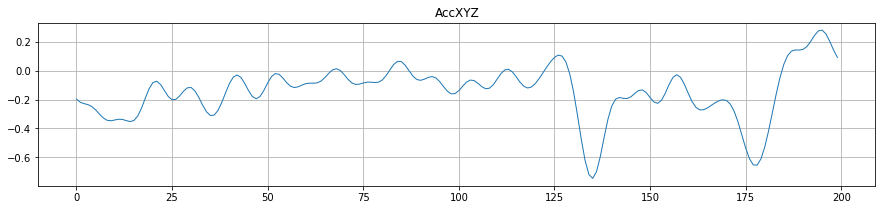

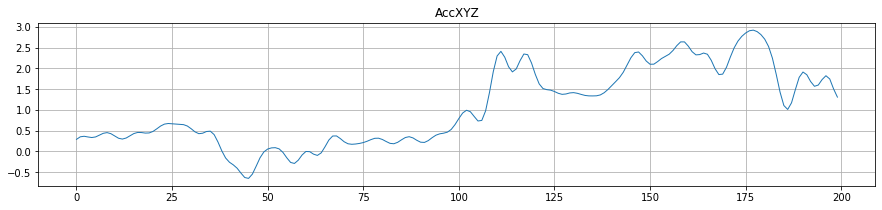

In [ ]:
example_length = 200

for name in data:
    try:
        plot_data(data[name]['clean_data'][:example_length], cols=['AccXYZ'], figsize=(15,3))
    except Exception as e:
        pass

### **Filter Functions (Moving average)**

When we apply a moving average of k elements on a time series, we loss the first (k-1)/2 elements and the last (k-1)/2 elements in the time series (if k is odd). This is the reason why we need to apply a mirroring* on the first (k-1)/2 elements. 
In general, when we apply a moving average, the peaks are moved forwad. This is why we implemented the mob2mean(similar to the scipy.filter.filfil function). It applies the function 2 times, first forward and then backward, so the peaks indexes should be the same of the originals (with mob2mean we can also apply an even value for k**)
    

*Mirroring means to replicate and overturn the original signal.

** When we use a even value for k in a moving average, the result falls inbetween the two central values (similar to the median problem). If we apply two moving average with even k, we will not have this problem anymore.

**References**

[Moving Average Filters](https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch15.pdf)


In [ ]:
# Mobile mean
def mm(vect, n):
    weights = np.ones(n*2+1) / (n*2+1) # All the weights are equals.
    return np.convolve(vect, weights, mode='valid')
    
def mob_mean(vect, n):
    vect_mirr = np.concatenate((np.concatenate((vect[n:0:-1],vect)),vect[(len(vect)-2):(len(vect)-n-2):-1]))
    vect_mm = mm(vect_mirr, n)
    return vect_mm

# Double mobile mean for peaks normalization (when we apply a mob.mean on a time series, the peaks are moved forward)
def mob2mean(vect,n):
    vect_mm = mob_mean(vect, n)
    vect_mm = mob_mean(vect_mm[::-1], n) 
    return vect_mm[::-1]

# Apply mob2mean and the eliminate the gravity force(~9.8g)
def my_filt(vec, k):
    new_vec = mob2mean(vect=vec, n=k)
    return np.subtract(new_vec, 9.8)

def get_alpha_indexes(vec, k=14, th=0.2):
    new_vec = np.absolute(np.subtract(vec, 9.8))
    new_vec = mob2mean(vect=new_vec, n=k)
    return np.argwhere(new_vec > th).flatten()

def get_alpha(vec, indexes, n_samp=20):
    splitted_vec = np.split(vec, indexes)
    alpha_vec = max(splitted_vec, key=len)
    assert len(alpha_vec) >= n_samp, f'The n° of samples for alpha are less then {n_samp}'
    alpha = alpha_vec.mean()    # Get the mean of the longest vector in splitted_vec
    return alpha

def get_all_alphas(df, **kwargs):
    name_ = kwargs.get(name, None)
    split_indexes = get_alpha_indexes(df['AccXYZ'])
    alphas = df.apply(get_alpha, indexes=split_indexes, axis=0).\
            rename({'AccX': 'alpha_X', 'AccY': 'alpha_Y',
                    'AccZ': 'alpha_Z', 'AccXYZ': 'alpha_XYZ'}).to_dict()
    assert abs(alphas['alpha_XYZ'] - 9.8) < 0.2,  f"The value of {name.title()}'s alpha_XYZ of {alphas['alpha_XYZ']} differs more than 9.8 ±0.2"
    return alphas

**NOTE:** Two asserts is implemented: 

1.   If there are less than 30 samples in the vector, it raises an error.
2.   If the value the value of alpha_XYZ is more/less than 9.8 ±0.1, an error is raised.

The **asserts** are very important for a production's code, because if the data exceed some paramenters, the model could not be good enough.



### **Get Current Axis Orientation**

**Problem :** All of us wear different cloths and put the smartphone in different pockets. So the accelerations  of the three axis are diffente when all of us walk forward (even if all of us has got the same walking "style"). This makes it easy to train a ML model, even with simple features. So, we need tha all our data are taken in the same way (formally, with the same asix orientations). This is why we apply a axises rotation. How?

1. Taking the orientation of X,Y and Z axis of each dataset.
2. Calculating the rotational matrix.
3. Rotate the data to the same axises referencing system.

In [ ]:
max_size = 4000

for name in data:
    df = data[name]['clean_data']
    alphas = get_all_alphas(df[:max_size])
    data[name]['params'].update(alphas)
    print(f"{name.title()}'s alphas are : {alphas}")

Pol's alphas are : {'alpha_X': -0.04283004007365434, 'alpha_Y': 5.058858312813748, 'alpha_Z': 8.263183391050546, 'alpha_XYZ': 9.692251679335865}
Matteo's alphas are : {'alpha_X': -3.058623845077877, 'alpha_Y': 9.219156446537937, 'alpha_Z': -0.8180551963856947, 'alpha_XYZ': 9.748571661011837}


In [ ]:
df = data['pol']['clean_data']
split_indexes = get_alpha_indexes(df['AccXYZ'])
alphas = df.apply(get_alpha, indexes=split_indexes, axis=0).\
            rename({'AccX': 'alpha_X', 'AccY': 'alpha_Y',
                            'AccZ': 'alpha_Z', 'AccXYZ': 'alpha_XYZ'}).\
            to_dict()

### **Rotate Axis**

First, we need to generate a rotation matrix given two points. The first one is given by the function "get_all_alphas" defined previously (with alpha_x ,alpha_y and alpha_z as coordinates). the second vector is the vec (0, 0, 9.8). The idea is to rotate the smartphone orizontally.


In [ ]:

def rotation_matrix_from_vectors(vec1, vec2=(0, 0, 9.8)):
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))

    return rotation_matrix

def apply_rotation(rotation_matrix, original_matrix):
    if isinstance(original_matrix, pd.core.frame.DataFrame):
        o_matrix = original_matrix.to_numpy().copy()
    else:
        o_matrix = original_matrix,copy()

    rotated_matrix = pd.DataFrame(rotation_matrix.dot(o_matrix.T).T)
    rotated_matrix.columns = columns
    rotated_matrix['AccXYZ'] = rotated_matrix.apply(lambda x: (x.AccX**2 + x.AccY**2 + x.AccZ**2)**(0.5), axis=1)

    return rotated_matrix

In [ ]:
for name in data:
    df = data[name]['clean_data']
    base_vec = (data[name]['params']['alpha_X'],
                data[name]['params']['alpha_Y'],
                data[name]['params']['alpha_Z'])

    r = rotation_matrix_from_vectors(base_vec)
    df = apply_rotation(r, df[columns])
    data[name]['clean_data'] = df
    print(f"\n{name.title()}'s dataset's head is :\n{df.head()}")


Pol's dataset's head is :
       AccX      AccY       AccZ     AccXYZ
0 -0.155174 -0.602730   9.284011   9.304849
1 -0.172402 -0.663765  10.433646  10.456160
2 -0.180856 -0.678585  10.661611  10.684715
3 -0.189219 -0.676433  10.257534  10.281555
4 -0.204940 -0.684798   9.656801   9.683220

Matteo's dataset's head is :
       AccX       AccY      AccZ     AccXYZ
0  3.854621  -9.177465  0.557656   9.969701
1  4.332410 -10.150053  0.716883  11.059262
2  4.173951  -9.611012  0.782598  10.507420
3  3.781302  -8.605527  0.756936   9.430074
4  3.563395  -8.126553  0.674605   8.899086


## **DATA INTO BINS**



In [ ]:
#separate data into bins given window size and overlap
size=50
overlap=5
df_bins=dict()
for name in data:
  df_bins[name]=[data[name]['clean_data'].loc[i:i+size-1,:] for i in range(0,len(data[name]['clean_data']),size-overlap) if i <len(data[name]['clean_data'])-overlap]


# **Features**

The feature extraction for gait analysis is performed first by extracting statistics from each bin and build a feature dataset.
The statistics are mean, median , standard deviation and root mean square.

Then, Fast Fourier Transform is applied to each bin as well to get the first 3 dominant frequencies as well as the energy given Parseval equation

Also, we make use of the library sensormotion. This Python package allows the user to extract human motion data, such as gait/walking dynamics, directly from accelerometer signals. In our case, it is used in order to retrieve peak times and values from a filtered acceleration signal. For this purpose, we make use of the mobile mean function secified previously. Then, sensormotion allows us to find the peak times and values, which correspond to the 'valleys' in the vertical signal filtered data plot (Y-axis).

 


In [ ]:
#Functions to retrieve statistical features
from numpy import mean, median, std, percentile, fft, abs, argmax

def Mean(data):
    'Returns the mean of a time series'
    return np.mean(data)

def Std(data):
    'Returns the standard deviation a time series'
    return np.std(data)

def RMS_XYZ(data):
    'Returs RMS of AccXYZ'
    return np.sqrt(np.mean(data**2))

def ABSDIFF(data):
  'Returns the (sum of??) the differences from between each magnitude sample and the mean of that window divided by the number of data points'
  for i in data.columns:
        return 1/len(data)*sum(abs(data[i]-mean(data[i])))


In [ ]:
!pip install sensormotion
import sensormotion as sm

In [ ]:
def peak_values_times(data):
  peak_times_ls=[]
  peak_values_ls=[]
  for i in range(len(data)):
    if len(data[i])==size:
      x_filtered = mob2mean(data[i]['AccY'],2)
      t=np.arange(0, size) * 10 
      peak_times, peak_values = sm.peak.find_peaks(time=t, signal=x_filtered,
                                              peak_type='valley',
                                              
                                              plot=False)
      peak_times_ls.append(peak_times)
      peak_values_ls.append(peak_values)
    else:
      pass

  return peak_values_ls
    


In [ ]:
peak_values=dict()

for name in data:
  peak_values[name]=peak_values_times(df_bins[name])

In [ ]:
median_dict=dict()
for name in data:
  median_dict[name]=[np.median(peak_values[name][i]) for i in range(len(peak_values[name]))]


Mean of empty slice.
invalid value encountered in double_scalars


In [ ]:
matteo_median_df=pd.DataFrame.from_dict(median_dict['matteo'])
pol_median_df=pd.DataFrame.from_dict(median_dict['pol'])
#yann_median_df=pd.DataFrame.from_dict(median_dict['yann'])

### **Statistics**

In [ ]:
def stats_func(data):
  means=pd.DataFrame([Mean(data[i]) for i in range(len(data))])
  stds=pd.DataFrame([Std(data[i]) for i in range(len(data))])
  #medians=pd.DataFrame([Median(data[i]) for i in range(len(data))])
  rms = pd.DataFrame([RMS_XYZ(data[i]['AccXYZ']) for i in range(len(data))])
  #absdiff=pd.DataFrame([ABSDIFF(data[i]) for i in range(len(data))])
  return pd.concat([means, stds,rms],axis=1)

#MATTEO
matteo_stats_df=stats_func(df_bins['matteo'])

#POL
pol_stats_df=stats_func(df_bins['pol'])

#YANN
#yann_stats_df=stats_func(bins_yann)

In [ ]:
#BUild personal feature dataframes
pol_feature_df=pd.concat([pol_stats_df,pol_median_df],axis=1)
matteo_feature_df=pd.concat([matteo_stats_df,matteo_median_df],axis=1)

pol_feature_df.columns = ['mean_AccX','mean_AccY','mean_AccZ','mean_AccXYZ','Std_AccX','Std_AccY','Std_AccZ','Std_AccXYZ','RMS_AccXYZ','peak_values']
matteo_feature_df.columns = ['mean_AccX','mean_AccY','mean_AccZ','mean_AccXYZ','Std_AccX','Std_AccY','Std_AccZ','Std_AccXYZ','RMS_AccXYZ','peak_values']

#Add index id
pol_feature_df['id']=1
matteo_feature_df['id']=2

In [ ]:
feature_df=pd.concat([pol_feature_df,matteo_feature_df])

### **FFT Features**

In [ ]:
def get_fft_features(df, columns=['AccX', 'AccY','AccZ','AccXYZ'], timestep=0.02):
    out = {}
    for col in columns:
        if col != 'AccXYZ':
            ax = col[-1].lower() # Axis' name
        else:
            ax = 'xyz'
        acc = df[col].copy().to_numpy()
        N = len(acc)
        fft_acc = np.absolute(fftpack.fft(acc)) / N
        freq = np.fft.fftfreq(N, d=timestep) 
        idxs = fft_acc.argsort()[-3:][::-1] # Top 3 dominant freq indexes
        for i, pos in enumerate(['1','2','3']):
            out[f'{pos}_dom_freq_{ax}'] = freq[i]
            out[f'{pos}_dom_value_{ax}'] = fft_acc[i]
            #print(freq[i], fft_acc[i])
        energy = np.sum(np.power(fft_acc,2)) # Get the energy using Parseval's theorem
        out[f'energy_{ax}'] = energy
    return out

In [ ]:
import scipy
from scipy import fftpack
from scipy import fft

In [ ]:
ls=[]

#def build_fft_df(data):
for name in data:
  for index in range(0,len(data[name]['clean_data']),size-overlap):
      df=data[name]['clean_data'][index:index+size]
      #df = data['pol']['clean_data'][500:700]
      ls.append(get_fft_features(df))

#print(ls)

In [ ]:
fft_df=pd.DataFrame()
for i in range(len(ls)):
  fft_temp=pd.DataFrame.from_dict(ls[i],orient='index')
  fft_df=fft_df.append(fft_temp.T)

print(len(fft_df))

  
  

2769


In [ ]:
#TAKEOUT YANNS DATA
#fft_df=fft_df[437:]
#len(fft_df)

In [ ]:
fft_df=fft_df.reset_index()
feature_df=feature_df.reset_index()

#Merge with feature_df
final_df=pd.concat([feature_df,fft_df],axis=1)
final_df.head()



,index,mean_AccX,mean_AccY,mean_AccZ,mean_AccXYZ,Std_AccX,Std_AccY,Std_AccZ,Std_AccXYZ,RMS_AccXYZ,peak_values,id,index,1_dom_freq_x,1_dom_value_x,2_dom_freq_x,2_dom_value_x,3_dom_freq_x,3_dom_value_x,energy_x,1_dom_freq_y,1_dom_value_y,2_dom_freq_y,2_dom_value_y,3_dom_freq_y,3_dom_value_y,energy_y,1_dom_freq_z,1_dom_value_z,2_dom_freq_z,2_dom_value_z,3_dom_freq_z,3_dom_value_z,energy_z,1_dom_freq_xyz,1_dom_value_xyz,2_dom_freq_xyz,2_dom_value_xyz,3_dom_freq_xyz,3_dom_value_xyz,energy_xyz
0,0,-0.165040,-0.738199,9.699424,9.731412,0.093658,0.203564,0.282984,0.284455,9.735569,-1.001824,1,0,0.0,0.165040,1.0,0.035227,2.0,0.042905,0.036010,0.0,0.738199,1.0,0.071421,2.0,0.083239,0.586377,0.0,9.699424,1.0,0.064254,2.0,0.057792,94.158910,0.0,9.731412,1.0,0.060001,2.0,0.059830,94.781297
1,1,-0.017573,-0.330135,9.676601,9.686127,0.056114,0.273545,0.215633,0.222049,9.688672,-0.832318,1,0,0.0,0.017573,1.0,0.017010,2.0,0.016351,0.003458,0.0,0.330135,1.0,0.147439,2.0,0.066295,0.183816,0.0,9.676601,1.0,0.016981,2.0,0.059445,93.683096,0.0,9.686127,1.0,0.020093,2.0,0.063152,93.870370
2,2,-0.103228,0.164016,9.660134,9.675946,0.211709,0.463931,0.219191,0.199774,9.678008,-0.189181,1,0,0.0,0.103228,1.0,0.080017,2.0,0.077881,0.055477,0.0,0.164016,1.0,0.166654,2.0,0.193821,0.242133,0.0,9.660134,1.0,0.023934,2.0,0.053824,93.366232,0.0,9.675946,1.0,0.010850,2.0,0.041602,93.663842
3,3,-0.242497,0.218251,9.726073,9.736657,0.185509,0.254746,0.170296,0.169567,9.738134,-0.054091,1,0,0.0,0.242497,1.0,0.093663,2.0,0.021625,0.093219,0.0,0.218251,1.0,0.117182,2.0,0.064520,0.112529,0.0,9.726073,1.0,0.016862,2.0,0.008805,94.625501,0.0,9.736657,1.0,0.019700,2.0,0.006781,94.831248
4,4,0.108589,-0.075976,9.660333,9.663029,0.162880,0.089246,0.064682,0.064283,9.663243,-0.214293,1,0,0.0,0.108589,1.0,0.014313,2.0,0.082271,0.038322,0.0,0.075976,1.0,0.042613,2.0,0.009731,0.013737,0.0,9.660333,1.0,0.017256,2.0,0.017967,93.326212,0.0,9.663029,1.0,0.016479,2.0,0.017589,93.378271


In [ ]:
#remove useless columns
final_df= final_df.drop(columns=['index'])
final_df.head()

,mean_AccX,mean_AccY,mean_AccZ,mean_AccXYZ,Std_AccX,Std_AccY,Std_AccZ,Std_AccXYZ,RMS_AccXYZ,peak_values,id,1_dom_freq_x,1_dom_value_x,2_dom_freq_x,2_dom_value_x,3_dom_freq_x,3_dom_value_x,energy_x,1_dom_freq_y,1_dom_value_y,2_dom_freq_y,2_dom_value_y,3_dom_freq_y,3_dom_value_y,energy_y,1_dom_freq_z,1_dom_value_z,2_dom_freq_z,2_dom_value_z,3_dom_freq_z,3_dom_value_z,energy_z,1_dom_freq_xyz,1_dom_value_xyz,2_dom_freq_xyz,2_dom_value_xyz,3_dom_freq_xyz,3_dom_value_xyz,energy_xyz
0,-0.165040,-0.738199,9.699424,9.731412,0.093658,0.203564,0.282984,0.284455,9.735569,-1.001824,1,0.0,0.165040,1.0,0.035227,2.0,0.042905,0.036010,0.0,0.738199,1.0,0.071421,2.0,0.083239,0.586377,0.0,9.699424,1.0,0.064254,2.0,0.057792,94.158910,0.0,9.731412,1.0,0.060001,2.0,0.059830,94.781297
1,-0.017573,-0.330135,9.676601,9.686127,0.056114,0.273545,0.215633,0.222049,9.688672,-0.832318,1,0.0,0.017573,1.0,0.017010,2.0,0.016351,0.003458,0.0,0.330135,1.0,0.147439,2.0,0.066295,0.183816,0.0,9.676601,1.0,0.016981,2.0,0.059445,93.683096,0.0,9.686127,1.0,0.020093,2.0,0.063152,93.870370
2,-0.103228,0.164016,9.660134,9.675946,0.211709,0.463931,0.219191,0.199774,9.678008,-0.189181,1,0.0,0.103228,1.0,0.080017,2.0,0.077881,0.055477,0.0,0.164016,1.0,0.166654,2.0,0.193821,0.242133,0.0,9.660134,1.0,0.023934,2.0,0.053824,93.366232,0.0,9.675946,1.0,0.010850,2.0,0.041602,93.663842
3,-0.242497,0.218251,9.726073,9.736657,0.185509,0.254746,0.170296,0.169567,9.738134,-0.054091,1,0.0,0.242497,1.0,0.093663,2.0,0.021625,0.093219,0.0,0.218251,1.0,0.117182,2.0,0.064520,0.112529,0.0,9.726073,1.0,0.016862,2.0,0.008805,94.625501,0.0,9.736657,1.0,0.019700,2.0,0.006781,94.831248
4,0.108589,-0.075976,9.660333,9.663029,0.162880,0.089246,0.064682,0.064283,9.663243,-0.214293,1,0.0,0.108589,1.0,0.014313,2.0,0.082271,0.038322,0.0,0.075976,1.0,0.042613,2.0,0.009731,0.013737,0.0,9.660333,1.0,0.017256,2.0,0.017967,93.326212,0.0,9.663029,1.0,0.016479,2.0,0.017589,93.378271


# **The Models**

In [ ]:
features=final_df.loc[:, final_df.columns != 'id'].fillna(0)
target=final_df[['id']]

In [ ]:
# Utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve,
                             RocCurveDisplay, precision_recall_curve,
                             PrecisionRecallDisplay, auc,
                             average_precision_score)

# The Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.ensemble import RandomForestClassifier

x_train, x_valid, y_train, y_valid = train_test_split(features, target, test_size=0.1, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [ ]:
N = len(features) 

models = {
    'model': {
            'SVM': SVC(probability=True, random_state= 1),
            'KNN': KNeighborsClassifier(n_jobs=-1),
            'RF': RandomForestClassifier(n_jobs=-1)
    },
    'best_model': {
            'SVM': None,
            'KNN': None,
            'RF': None
    },
    'params': {
            'KNN':{'n_neighbors': range(1, int(N**0.5),2), 'weights': ['uniform', 'distance'], 'p': [1,2], 'metric':['minkowski', DistanceMetric.get_metric('mahalanobis', V=np.cov(x_train))],
                   'algorithm':['ball_tree', 'kd_tree']},
            'SVM':{'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf', 'poly']},
            'RF': {'n_estimators': range(100, 500, 200),'max_depth' : [4,5,6,7,8], 'criterion' :['gini', 'entropy']}
    },
    'performance': {
            'SVM': None,
            'KNN': None,
            'RF': None
    }
}

def my_GSCV(model, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, cv=5, scoring='accuracy', verbose=1):
#def my_GSCV(model, x_train={}, x_test={}, y_train={}, y_test={}, cv=5, scoring='accuracy', verbose=10):
    y_train = y_train.iloc[:,0].ravel()
    y_test = y_test.iloc[:,0].ravel()
    model_ = models['model'][model]
    params_ = models['params'][model]

    grid = GridSearchCV(estimator=model_,param_grid=params_, cv=cv, scoring=scoring, return_train_score=True,  verbose=verbose)
    grid.fit(x_train, y_train)
    print(f"{model}'s best score is:\n{grid.best_score_}")
    print(f"\n{model}'s best params are:\n{grid.best_params_}")

    best_model = grid.best_estimator_

    y_pred = best_model.predict(x_test)
    y_score = best_model.predict_proba(x_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f" % acc)

    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2]).plot()
    print(f'y_pred: {y_pred} \n\ny_score: {y_score}')
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=2)
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'{model} estimator').plot()
    prec, recall, _ = precision_recall_curve(y_test, y_score,
                                        pos_label=2)
    average_precision = average_precision_score(y_test, y_score)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, estimator_name=f'{model} estimator', average_precision=average_precision).plot()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    return best_model, acc


## **KNN**

**Note:**
In the Grid_search we are going to use these parameters for model optimization:


1.   **n_neighbors** = range(1, int(N/2)) : The number of sample to use for classification. An empirical value is N^1/2
2.   **weights** = ['uniform', 'distance'] : 

    *   **uniform** : uniform weights. All points in each neighborhood are weighted equally.
    *   **distance** : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

3.   **metric** :
    *   **Minkowski** : With p = 1 it's the Manhattan Distance, p = 2 it's theEuclideian Distance.
    *   **Mahalanobis** : The Mahalanobis distance is a measure of the distance between a point P and a distribution D. It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D.

In [ ]:
knn_model, accuracy = my_GSCV(model='KNN')
models['best_model']['KNN'] = knn_model
models['performance']['KNN'] = accuracy

## **SVM**

**Note:**
In the Grid_search we are going to use these parameters for model optimization:

1.   **gamma** : Kernel coefficient for ‘rbf’, ‘poly’
2.   **kernel** : Type of kernel.
3.   **C** : Regularization parameter. The strength of the regularization is inversely proportional to C. The penalty is a squared l2 penalty.



Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.1min finished


SVM's best score is:
0.9969887029130616

SVM's best params are:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 1.00
y_pred: [2 1 2 2 2 1 2 2 1 2 1 1 2 1 1 1 2 2 1 2 2 1 1 2 2 1 1 1 2 1 2 1 1 2 1 1 2
 2 1 2 1 1 2 2 2 2 1 2 2 1 1 1 2 1 1 1 2 1 2 2 1 1 1 1 2 2 2 1 1 1 1 1 1 2
 2 2 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1 2 1 1 1 2 2 2 2 1 2 2 1 1 2 1 2
 2 1 2 1 1 2 1 1 2 1 1 1 1 2 1 1 1 2 1 2 2 2 1 2 2 2 1 1 1 2 1 1 1 1 2 2 2
 1 1 1 2 1 1 1 1 1 2 2 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 1 2 1 1 1 1 1
 1 2 1 1 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 2 1 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1
 1 2 1 2 2 1 1 2 1 1 1 1 2 2 1 2 1 2 1 1 1 2 2 1 2 1 2 2 2 2 2 1 2 1 1 2 2
 2 2 1 2 1 1 2 1 2 1 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 2 1
 2 1 2 2 2 2 1 2 1 2 1 1 1 1 1 2 2 2 1 1 2 1 1 1 1 1 2 2 2 2 2 1 1 1 1 2 2
 2 2 1 1 2 1 2 1 2 2 2 1 1 1 2 1 2 2 2 1 2 1 1 2 2 1 1 1 2 1 2 1 1 1 2 2 2
 1 1 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2 1 1 2 1 2 1 2 1 1 1 1 1
 1 1 1 2 1 2 2 2 2 1 1 1 2 1 1 1 2 2 2 2 2 

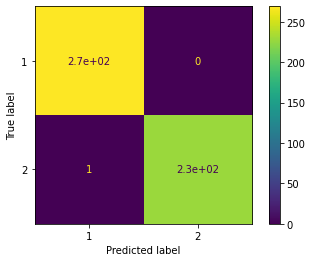

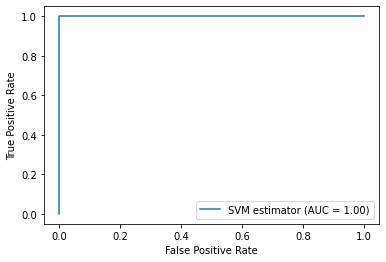

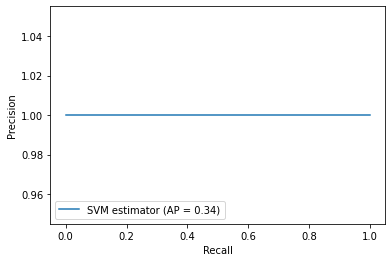

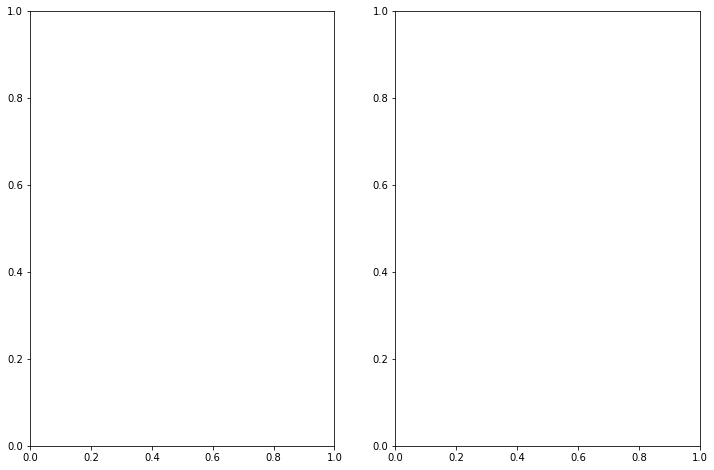

In [ ]:
svm_model, accuracy = my_GSCV(model='SVM')
models['best_model']['SVM'] = svm_model
models['performance']['SVM'] = accuracy

## **Random Forest**

1. **n_estimatorsint**: The number of trees in the forest.
2. **max_depth** :  The maximum depth of the tree. 
3. **criterion**: 
    * **Gini**: for the Gini impurity criterion.
    * **Entropy**: information gain criterion.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


RF's best score is:
0.9989949748743718

RF's best params are:
{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}
Accuracy: 1.00
y_pred: [2 1 2 2 2 1 2 2 1 2 1 1 2 1 1 1 2 2 1 2 2 1 1 2 2 1 1 1 2 1 2 1 1 2 1 1 2
 2 1 2 1 1 2 2 2 2 1 2 2 1 1 1 2 1 1 1 2 1 2 2 1 1 1 1 2 2 2 1 1 1 1 1 1 2
 2 2 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1 2 1 1 1 2 2 2 2 1 2 2 1 1 2 1 2
 2 1 2 1 1 2 1 1 2 1 1 1 1 2 1 1 1 2 1 2 2 2 1 2 2 2 1 1 1 2 1 1 1 1 2 2 2
 1 1 1 2 1 1 1 1 1 2 2 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 1 2 1 1 1 1 1
 1 2 1 1 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 2 1 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1
 1 2 1 2 2 1 1 2 1 1 1 1 2 2 1 2 1 2 1 1 1 2 2 1 2 1 2 2 2 2 2 1 2 1 1 2 2
 2 2 1 2 1 1 2 1 2 1 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 2 1
 2 1 2 2 2 2 1 2 1 2 1 1 1 1 1 2 2 2 1 1 2 1 1 1 1 1 2 2 2 2 2 1 1 1 1 2 2
 2 2 1 1 2 1 2 1 2 2 2 1 1 1 2 1 2 2 2 1 2 1 1 2 2 1 1 1 2 1 2 1 1 1 2 2 2
 1 1 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2 1 1 2 1 2 1 2 1 1 1 1 1
 1 1 1 2 1 2 2 2 2 1 1 1 2 1 1 

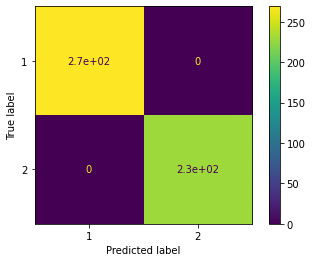

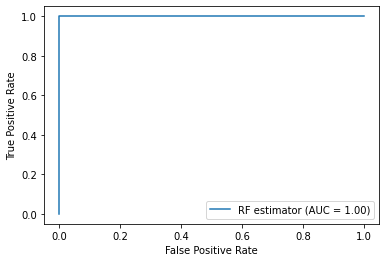

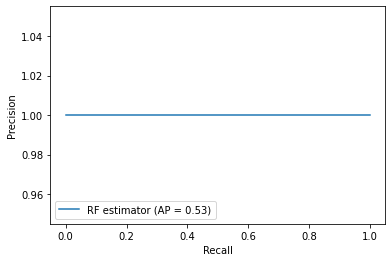

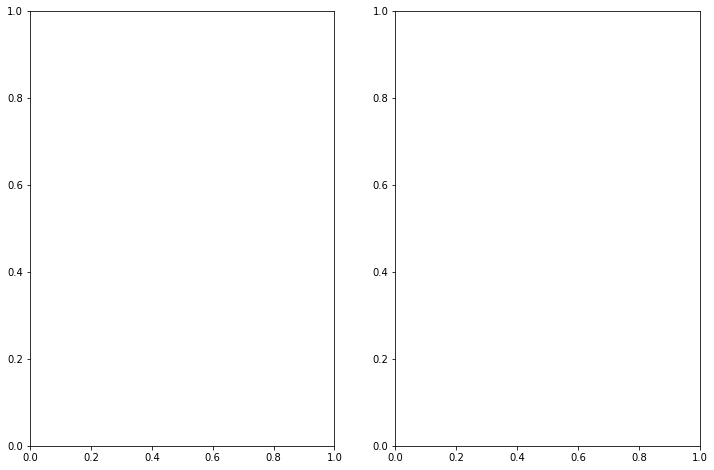

In [ ]:
rf_model, accuracy = my_GSCV(model='RF')
models['best_model']['RF'] = rf_model
models['performance']['RF'] = accuracy

# Analysis

In [ ]:
%pip install shap
import shap

In [ ]:
# Select the best model
bm = models['performance']
best_model_name = max(bm, key=bm.get)
best_model = models['best_model'][best_model_name]
print(f"The best model is {best_model_name}\n\nThe model's accuracy is: {models['performance']}")

The best model is KNN

The model's accuracy is: {'SVM': 0.9979959919839679, 'KNN': 1.0, 'RF': 1.0}


In [ ]:
best_model = models['best_model']['RF']

## Feature Importance Plot

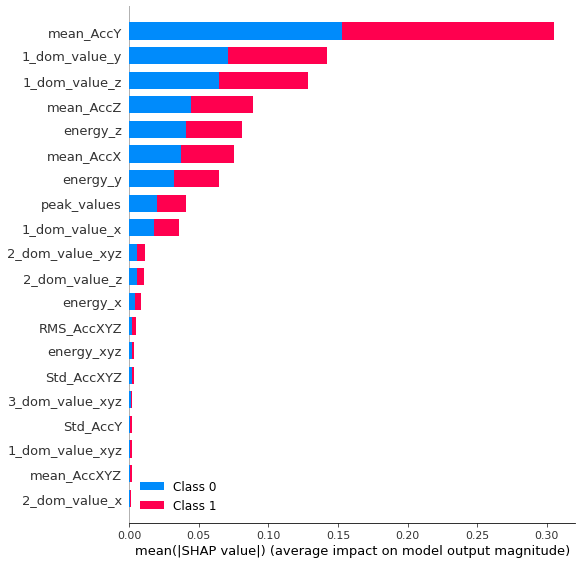

In [ ]:
explainer = shap.Explainer(best_model, masker=None)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

# Model Validation

Accuracy: 1.00


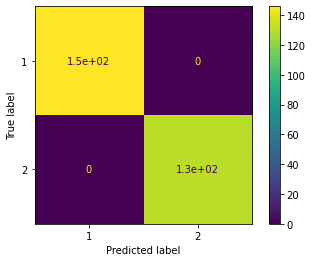

In [ ]:
y_pred_valid = best_model.predict(x_valid)
y_score_valid = best_model.predict_proba(x_valid)[:,1]
acc_valid = accuracy_score(y_valid, y_pred_valid)
print("Accuracy: %.2f" % acc_valid)

cm_valid = confusion_matrix(y_valid, y_pred_valid)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_valid, display_labels=[1,2]).plot()

# References

* [What can we learn from the accelerometer data?
A close look into privacy](http://cs229.stanford.edu/proj2014/Manikantan%20Shila,What%20Can%20You%20Learn%20From%20Accelerometer%20Data.pdf)

* [Feature Engineering for Activity Recognition from Wrist-worn Motion
Sensors](https://core.ac.uk/download/pdf/193493071.pdf)

*   [Tilt Sensing Using a Three-Axis
Accelerometer](https://www.nxp.com/docs/en/application-note/AN3461.pdf)
*   [ Gravity-Based Characterization of
Three-Axis Accelerometers in Terms of
Intrinsic Accelerometer Parameters](https://nvlpubs.nist.gov/nistpubs/jres/122/jres.122.032.pdf)
*   [Inclination Measurement of Human Movement Using
a 3-D Accelerometer With Autocalibration](https://ris.utwente.nl/ws/portalfiles/portal/6680661)
*   [Indoor Positioning
using Sensor-fusion
in Android Devices](https://www.diva-portal.org/smash/get/diva2:475619/FULLTEXT02.pdf)